# Import necessary libraries

In [1]:
from sklearn.linear_model import LinearRegression as LR
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.base import clone
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sweetviz as sv
import copy
import lightgbm as lgb
import os
import sys

/userdata/miniforge-pypy3/envs/dataICU/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load and preprocess data set

In [2]:
EICU_DATA_PATH_DYNAMIC = "/userdata/lucabri/icu-experiments/data/processed/eicu_dynamic.parquet"
EICU_DATA_PATH_STATIC = "/userdata/lucabri/icu-experiments/data/processed/eicu_static.parquet"
HIRID_DATA_PATH_DYNAMIC = "/userdata/lucabri/icu-experiments/data/processed/hirid_dynamic.parquet"
HIRID_DATA_PATH_STATIC = "/userdata/lucabri/icu-experiments/data/processed/hirid_static.parquet"
MIMIC_DATA_PATH_DYNAMIC = "/userdata/lucabri/icu-experiments/data/processed/mimic_dynamic.parquet"
MIMIC_DATA_PATH_STATIC = "/userdata/lucabri/icu-experiments/data/processed/mimic_static.parquet"
MIIV_DATA_PATH_STATIC = "/userdata/lucabri/icu-experiments/data/processed/miiv_static.parquet"
MIIV_DATA_PATH_DYNAMIC = "/userdata/lucabri/icu-experiments/data/processed/miiv_dynamic.parquet"

## Preprocessing

In [3]:
def preprocess(DYNAMIC_PATH, STATIC_PATH, impute=True):
    # komisch: Malte macht log von bicar aber nicht von bili_dir --> würde ich swappen
    columns_to_transform = ["alp", 'alt', 'ast', 'bili', 'bili_dir', 'bnd', 'bun', 'ck', 'ckmb',
                            'crea', 'crp', 'fgn', 'fio2', 'glu', 'hgb', 'inr_pt', 'lact', 'lymph',
                             'methb', 'neut', 'o2sat', 'phos', 'plt', 'pco2', 'ph', 'po2', 'ptt', 
                             'urine', 'tnt', 'wbc']

    df_dynamic = pd.read_parquet(DYNAMIC_PATH)
    df_dynamic[columns_to_transform] = df_dynamic[columns_to_transform].apply(np.log)
    df_static = pd.read_parquet(STATIC_PATH)

    if "sex" in df_static.columns:
        df_static['sex'] = df_static['sex'].apply(lambda x: 0 if x == 'Male' else 1)

    # Rename columns to have a unified column name for IDs and time across datasets
    column_renames = {
        'icustay_id': 'stay_id', 
        'patientunitstayid': 'stay_id',
        'patientid': 'stay_id',
        'charttime': 'time',
        'labresultoffset': 'time',
        'datetime': 'time'
    }
    df_dynamic.rename(columns=column_renames, inplace=True)
    df_static.rename(columns=column_renames, inplace=True)

    # Group and calculate mean for day 1 and day 3
    df_dynday1 = df_dynamic[lambda x: x["time"].dt.days == 0].groupby("stay_id").mean()
    df_dynday3 = df_dynamic[lambda x: x['time'].dt.days == 2].groupby("stay_id").mean()
    
    # Merge with static features and fill NaN values
    df_day1 = pd.merge(df_dynday1, df_static, on="stay_id", how="outer", validate="m:1").set_index('stay_id')
    df_day3 = pd.merge(df_dynday3, df_static, on="stay_id", how="outer", validate="m:1").set_index('stay_id')

    # drop the 'time' column since it's not needed
    # drop crp and methb since only two values recorded
    df_day1.drop(columns=["time"], inplace=True)
    df_day3.drop(columns=["time"], inplace=True)

    if impute==True:
            
        # Detect -inf values in DataFrame day1
        inf_mask = df_day1.isin([-np.inf])
        # Add an indicator column based on whether -inf was replaced
        df_day1['inf_replaced'] = inf_mask.any(axis=1).astype(int)
        # Replace -inf with NaN
        df_day1.replace(-np.inf, np.nan, inplace=True)
        
        # Perform an inner join on the 'stay_id' column
        df = pd.merge(df_day3['hr'], df_day1, on='stay_id', how='inner')
        df.rename(columns={'hr_x': 'hr3',
                        'hr_y': 'hr1'}, inplace=True)
        
        df.dropna(subset=["hr3", "hr1"], inplace=True)

        # Create a new DataFrame to hold the indicators
        indicators = df.isna().astype(int)

        # Rename the indicator columns to distinguish them
        indicators.columns = [str(col) + '_was_nan' for col in df.columns]

        # Replace NaN values with the mean of the column
        for column in df.columns:
            df[column].fillna(df[column].mean(), inplace=True)

        # Concatenate the original DataFrame with the indicator DataFrame
        df = pd.concat([df, indicators], axis=1)
    
    else:
        # Replace -inf with NaN
        df_day1.replace(-np.inf, np.nan, inplace=True)
        
        # Perform an inner join on the 'stay_id' column
        df = pd.merge(df_day3['hr'], df_day1, on='stay_id', how='inner')
        df.rename(columns={'hr_x': 'hr3',
                        'hr_y': 'hr1'}, inplace=True)
        
        df.dropna(subset=["hr3", "hr1"], inplace=True)
    return df

In [4]:
df_eicu = preprocess(EICU_DATA_PATH_DYNAMIC, EICU_DATA_PATH_STATIC)

In [5]:
df_hirid = preprocess(HIRID_DATA_PATH_DYNAMIC, HIRID_DATA_PATH_STATIC)

In [6]:
df_mimic = preprocess(MIMIC_DATA_PATH_DYNAMIC, MIMIC_DATA_PATH_STATIC)

In [7]:
df_miiv = preprocess(MIIV_DATA_PATH_DYNAMIC, MIIV_DATA_PATH_STATIC)

## Automated EDA

In [ ]:
dataframes = {
    'eicu': df_eicu,
    'hirid': df_hirid,
    'mimic': df_mimic
}

for name, df in dataframes.items():

    cols_to_drop = [col for col in df.columns if '_was_nan' in col]
    df = df.drop(columns=cols_to_drop)

    # Analyze the dataset
    report = sv.analyze(df, target_feat='hr3')

    # Display the report as HTML
    report.show_html(f'{name}_Report.html')

# Predictions

## Training - What is the difference between continuous learning and refit?

In [181]:
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 10, 20, 30],
    'max_leaf_nodes': [None, 10, 20],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10]
}

In [220]:
X_train = df_eicu.drop('hr3', axis=1)
y_train = df_eicu['hr3']

ols = LR()
ols.fit(X_train,y_train)

# generate a feature name
feature_name = [col for col in X_train.columns]

# specify configurations as a dict
params_lgbm = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'l2',
    'random_state': 42,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'verbose': -1  # Suppresses standard output
}
params_rf = {
    'boosting_type': 'rf',
    'objective': 'regression',
    'metric': 'l2',
    'random_state': 42,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'verbose': -1  # Suppresses standard output
}
lgb_train = lgb.Dataset(data=X_train, label=y_train,free_raw_data=False)
lgbm = lgb.train(params_lgbm,
                lgb_train,
                feature_name=feature_name,
                valid_sets=lgb_train,
                num_boost_round=10
                )
rf = lgb.train(params_rf,
                lgb_train,
                feature_name=feature_name,
                valid_sets=lgb_train,
                num_boost_round=10,
                )
lgbm.save_model('lgbm_trained_model.txt')
rf.save_model('rf_trained_model.txt')

print("Training MSE LGBM:", mean_squared_error(y_train, lgbm.predict(X_train)))
print("Training MSE RF:", mean_squared_error(y_train, rf.predict(X_train)))
print("Training MSE OLS:", mean_squared_error(y_train, ols.predict(X_train)))

X_test_hirid, X_test_mimic, X_test_miiv = df_hirid.drop('hr3', axis=1), df_mimic.drop('hr3', axis=1), df_miiv.drop('hr3', axis=1)
y_test_hirid, y_test_mimic, y_test_miiv = df_hirid['hr3'], df_mimic['hr3'], df_miiv['hr3']
# Do nothing prediction
dummy_mse_hirid = mean_squared_error(y_test_hirid, np.full_like(y_test_hirid, y_train.mean()))
dummy_mse_mimic = mean_squared_error(y_test_mimic, np.full_like(y_test_mimic, y_train.mean()))
dummy_mse_miiv = mean_squared_error(y_test_miiv, np.full_like(y_test_miiv, y_train.mean()))
print(f'Do nothing-mse on Hirid is {dummy_mse_hirid}, on Mimic is {dummy_mse_mimic}, on Miiv is {dummy_mse_miiv}')

# Hypothesis: Higher MSE on Mimic is caused by children
X_test_mimic = df_mimic[df_mimic["age"]>18].drop('hr3', axis=1)
y_test_mimic = df_mimic[df_mimic["age"]>18]['hr3']
dummy_mse_mimic = mean_squared_error(y_test_mimic, np.full_like(y_test_mimic, y_train.mean()))
print(f'Do nothing-mse on Mimic (without children) is {dummy_mse_mimic}')


Training MSE LGBM: 166.32518032864854
Training MSE RF: 152.31950765638805
Training MSE OLS: 148.35704250894904
Do nothing-mse on Hirid is 278.0011333281888, on Mimic is 548.8081578499456, on Miiv is 243.3661983075155
Do nothing-mse on Mimic (without children) is 226.98293268716793


In [ ]:
""""""""""
Do only if access to Euler otherwise pc goes in brrrr state
#grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
#grid_search.fit(X_train, y_train)
#best_training_model = grid_search.best_estimator_
#print("Finished grid search and selected best estimator \n")
"""""""""""

In [207]:
test_dataframes = {
    'hirid': df_hirid,
    'mimic': df_mimic,
    'miiv': df_miiv
    }
mse_values = {name: {'lgbm': [], 'rf': [], 'ols': []} for name in test_dataframes}
n_fine_tune_range = [25, 50, 100, 200, 400, 800, 1600]
for name, df in test_dataframes.items():
    X_test = df.drop('hr3', axis=1)
    y_test = df['hr3']

    mse_values[name]['lgbm'].append(mean_squared_error(y_test,lgbm.predict(X_test,num_iteration=lgbm.best_iteration))) # Base line prediction - without fine tuning
    mse_values[name]['rf'].append(mean_squared_error(y_test,rf.predict(X_test,num_iteration=rf.best_iteration))) # Base line prediction - without fine tuning
    mse_values[name]['ols'].append(mean_squared_error(y_test,ols.predict(X_test)))
    
    for n_fine_tune in n_fine_tune_range:
        X_fine_tune, X_evaluate, y_fine_tune, y_evaluate = train_test_split(X_test, y_test, train_size=n_fine_tune, random_state=42)
        #print(X_fine_tune.shape, X_evaluate.shape)

        lgbm = lgb.Booster(model_file='lgbm_trained_model.txt')
        refit_lgbm = lgbm.refit(X_fine_tune,y_fine_tune,validate_features=True)
        mse_values[name]['lgbm'].append(mean_squared_error(y_evaluate, refit_lgbm.predict(X_evaluate,num_iteration=lgbm.best_iteration)))

        rf = lgb.Booster(model_file='rf_trained_model.txt')
        refit_rf = rf.refit(X_fine_tune,y_fine_tune,validate_features=True)
        mse_values[name]['rf'].append(mean_squared_error(y_evaluate, refit_rf.predict(X_evaluate,num_iteration=rf.best_iteration)))
        
        mse_values[name]['ols'].append(mean_squared_error(y_evaluate, ols.predict(X_evaluate)))

<Axes: >

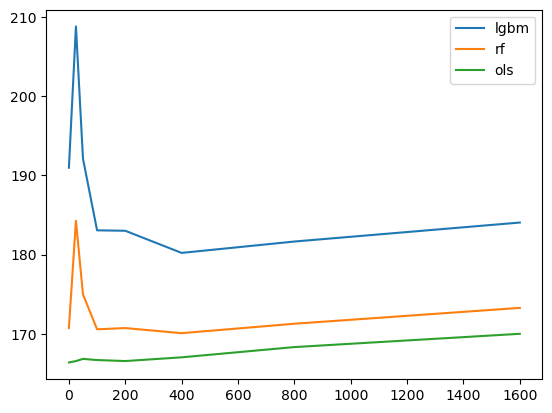

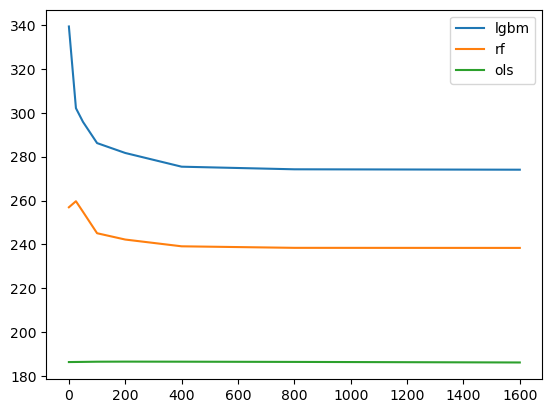

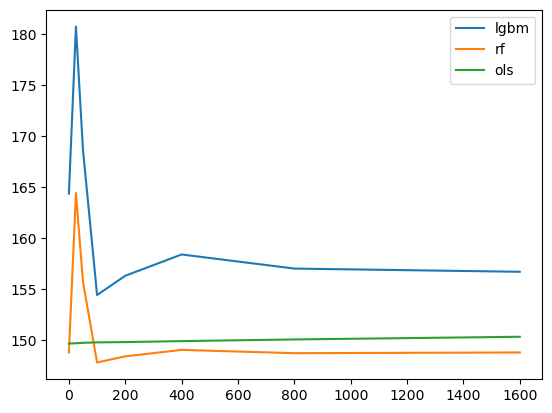

In [221]:
mse_hirid_df = pd.DataFrame(mse_values['hirid'])
mse_hirid_df.title='EICU on HIRID'
mse_hirid_df.index = [0, 25, 50, 100, 200, 400, 800, 1600]
mse_mimic_df = pd.DataFrame(mse_values['mimic'])
mse_mimic_df.title='EICU on MIMIC'
mse_mimic_df.index = [0, 25, 50, 100, 200, 400, 800, 1600]
mse_miiv_df = pd.DataFrame(mse_values['miiv'])
mse_miiv_df.title='EICU on MIIV'
mse_miiv_df.index = [0, 25, 50, 100, 200, 400, 800, 1600]
mse_hirid_df.plot()
mse_mimic_df.plot()
mse_miiv_df.plot()

In [218]:
mse_hirid_df["ols"]

0       166.386174
25      166.561511
50      166.839867
100     166.693752
200     166.566098
400     167.035664
800     168.330407
1600    170.006601
Name: ols, dtype: float64

### Anchor Regression + Residual RF  --> location als anchor

In [210]:
gamma=2
# Centering
X_centered = X_train.drop(columns=['age', 'height', 'sex', 'weight']) - X_train.drop(columns=['age', 'height', 'sex', 'weight']).mean()
Y_centered = y_train - y_train.mean()

# Convert A to a NumPy array if it's a DataFrame for matrix operations
A_matrix = X_train[['age', 'sex', 'weight', 'height']].values   
# Fit a linear regression model for each independent variable in X_centered using A_matrix
residuals_X = []
fitted_values_X = []
residuals_y = []
fitted_values_y = []
for column in X_centered.columns:
    model = LR()
    model.fit(A_matrix, X_centered[column])
    residuals_X.append(X_centered[column] - model.predict(A_matrix))
    fitted_values_X.append(model.predict(A_matrix))

model = LR()
model.fit(A_matrix, Y_centered)
residuals_y.append(Y_centered - model.predict(A_matrix))
fitted_values_y.append(model.predict(A_matrix))

# Convert lists of residuals and fitted values to NumPy arrays
residuals_X_matrix = np.column_stack(residuals_X)
fitted_values_X_matrix = np.column_stack(fitted_values_X)
residuals_y = np.column_stack(residuals_y)
fitted_values_y = np.column_stack(fitted_values_y)

# Compute anchor_data by adding residuals to the scaled fitted values
anchor_data = residuals_X_matrix + np.sqrt(gamma) * fitted_values_X_matrix
anchor_data_target = residuals_y + np.sqrt(gamma) * fitted_values_y

anchor_reg = LR()
anchor_reg.fit(anchor_data, anchor_data_target)
pred_anchor = anchor_reg.predict(anchor_data)

res_anchor = anchor_data_target - pred_anchor
lgb_train = lgb.Dataset(data=X_centered, label=res_anchor,free_raw_data=False)
anchor_rf = lgb.train(params_rf,
                lgb_train,
                valid_sets=lgb_train,
                num_boost_round=10,
                )
pred_rf = anchor_rf.predict(X_centered).reshape(-1,1)
pred_anchor_rf = pred_anchor + pred_rf
print(mean_squared_error(Y_centered.values.reshape(-1, 1),pred_anchor_rf))

/userdata/miniforge-pypy3/envs/dataICU/lib/python3.12/site-packages/lightgbm/basic.py:300: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')


146.62963590871328
